# Improved Bound Constraint differing across domain

We are interested still in protecting just the outputs. Reiterating the previous paper, we need to find:

$$||f_D(x_*) - f_{D'}(x_*)||^2_H$$

We can express this difference as:

$$f_D(x_*) - f_{D'}(x_*) = \sum_{i=1}^n k(x_*,x_i) \; (\alpha_i - \alpha_i')$$

We also noted that 
$$\mathbf{\alpha} - \mathbf{\alpha}' = K^{-1} (\mathbf{y}-\mathbf{y}')$$

The change we propose at this point is that, rather than just put a bound on the values of $k(\cdot,\cdot)$ we calculate these values for every test point.

So rather than just accept that $-1<k(\cdot,\cdot)<1$ we actually input the value of this function. 

Thus the bound is:

$$\text{max}_j\; \text{abs}\left( \sum_{i=1}^n { k(x_*,x_i) \; (K^{-1})_{ij} } \right) \Delta_y$$

So we need to calculate the kernel value from a test point $x_*$ to each training point $x_i$ (shape, transposed, 1xN). Such a vector will then be multiplied by $K^{-1}$ (NxN) such that each column is multiplied element wise with the $k$s. The resulting 1xN vector is the result of whether the differing element of $\mathbf{y}$ lies at that index. We find the absolute change, as that's what we want to protect. Find the largest of these, and then scale by the largest change in y.

$$\text{max} \; \left[ \text{abs} \left(\mathbf{k}_*^{\top} \mathbf{K}^{-1} \right) \right] \Delta_y$$

For speed we can consider the matrix of covariance between all test and training points $\mathbf{K}_*$, we want the maximum of each row:

$$\text{max}_{by\;row} \; \left[ \text{abs} \left(\mathbf{K}_*^{\top} \mathbf{K}^{-1} \right) \right] \Delta_y$$

## Error!

This currently can't be applied to each test point as we will no longer be adding a GP sample to the mean!

See bottom of doc for a new version that does manage this properly.

## Notes on: Inducing inputs using the improved bound constraint

We need to apply the above to inducing inputs. We just need to consider the calculation of $\mathbf{\alpha}$ for the inducing inputs, and then use the same expression as above.

From the paper,

$\mu_* = \mathbf{k}_*^\top Q_{uu}^{-1} K_{uf} \left( \Lambda + \sigma^2 I \right)^{-1} \mathbf{y}$

where $Q_{uu} = K_{uu} + K_{uf}\left( \Lambda + \sigma^2 I \right)^{-1} K_{fu}$ and the matrix $\Lambda = \text{diag}(\mathbf{\lambda})$ where the diagonal elements are $\lambda_i = K_{ii} - \mathbf{k}_i^\top K_{uu}^{-1} \mathbf{k}_i$.

So we just need to substitute in,

$\mathbf{K}_{pseudo}^{-1} = Q_{uu}^{-1} K_{uf} \left( \Lambda + \sigma^2 I \right)^{-1}$

thus,

$$\text{max}_{by\;row} \; \left[ \text{abs} \left(\mathbf{K}_*^{\top} \mathbf{K}_{pseudo}^{-1} \right) \right] \Delta_y$$

where $\mathbf{K}_*$ is now the covariance between inducing inputs and test inputs.

Applying this to the fish length example;

In [ ]:
import dp4gp_datasets as datasets
import dp4gp
import GPy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fishdata = datasets.load_fishlength()

X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
#X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
plt.plot(X,Y,'o',alpha=0.4,markersize=5)
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')


In [ ]:
test_inputs = np.arange(0,300,1)
pseudo_inputs = np.array([0,120])
lengthscales = 50.0
sigma = 0.05
delta = 0.01
eps = 500.0
sens = 4.0
normal = True

test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)

We now have four results,

- normal GP
- inducing variable GP
- normal GP, but with the kernel computed for each test point (i.e. test point specific)
- test point specific IV GP

The results for the above fish example are as follows;

In [ ]:
print("Normal GP     %03.3f" % normal_msense)
print("IV GP         %3.3f" % pseudo_msense)
print("TPS normal GP %3.3f" % np.mean(normal_peroutput_msense))
print("TPS IV GP     %3.3f" % np.mean(pseudo_peroutput_msense))

The TPS do far better on average (although it depends on which points you care about! The figure below illustrates how the sensitivity varies. The horizontal line near the top indicates the sensitivity of the IV GP.

In [ ]:
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.03)
#plt.hlines(pseudo_msense,0,250)
plt.xlabel('Fish Age / days')
plt.ylabel('$b(x_*, K^{-1})$')
plt.plot(pseudo_inputs,[0.02,0.02],'xb')
plt.savefig('fish_cloaking.pdf')

The vertical lines along the bottom of the figure indicate where the training data is.

Note that the sensitivity increases beyond the last set of data. I assume this is because these test points depend on fewer training data, and so are more easily altered by single training point values. To further demonstrate this we add a new fish of 200 days,

In [ ]:
plt.hist(normal_peroutput_msense,np.arange(0.1,0.2,0.001));
np.mean(normal_peroutput_msense[(test_inputs>25) & (test_inputs<140)]<0.12)

In [ ]:
X = np.hstack([300,X])
Y = np.hstack([10,Y])
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)


In [ ]:
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.1)
#plt.hlines(pseudo_msense,0,250)

In [ ]:
print("Normal GP     %03.3f" % normal_msense)
print("IV GP         %3.3f" % pseudo_msense)
print("TPS normal GP %3.3f" % np.mean(normal_peroutput_msense))
print("TPS IV GP     %3.3f" % np.mean(pseudo_peroutput_msense))

One can see that the sensitivity of the normal GP is greatest around this single outlying training point. The inducing input GP is protected from this as there are no inducing inputs near the training point.

This method seems to have many intuitive features;

 - the sensitivity approaches zero far from the training data (where we return to the GP prior).
 - conversely, the more training data in a locale, the less the sensitivity too. However, this seems to sometimes be cancelled out by increased sensitivity in the surrounding area, presumably the effect of the gradient of the mean can still be strongly affected by individual training point, as one moves away from a concentration of training data?
 - we can reduce the sensitivity by placing inducing inputs near the higher concentrations of training points, and away from single outliers. This might explain why the TPS IV GP method above did poorly;
 
To further investigate these points, we add 9 more points and an inducing input, all around 200 days;

In [ ]:
X = np.hstack([201,199,198,196,202,204,205,206,208,X])
Y = np.hstack([10,12,13,14,15,16,14,13,11,Y])
pseudo_inputs = np.array([0,40,80,120,160,200])

test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)


In [ ]:
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.1)
#plt.hlines(pseudo_msense,0,250)

In [ ]:
pseudo_inputs = np.array([17,42,72,98,125,140,170,200])
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
plt.plot(test_inputs,pseudo_peroutput_msense)
plt.plot(test_inputs,normal_peroutput_msense)
plt.vlines(X,0,0.1)
#plt.hlines(pseudo_msense,0,250)

The inducing variables potentially are useful in situations with lots of outliers, or higher numbers of dimensions.

### Demo with outputs (fixed noise)

In [ ]:
plotid = 1
plt.figure(figsize=[10,4])
for normal in [True,False]:
    plt.subplot(1,2,plotid)
    plotid+=1
    fishdata = datasets.load_fishlength()

    test_inputs = np.arange(0,360,1)
    pseudo_inputs = np.array([0,120])
    lengthscales = 100.0
    sigma = 0.1
    delta = 0.01
    sens = 4.0

    if normal:
        eps = 100
    else:
        eps = 100

    print eps
    X = fishdata[:,1] #age of fishes (days)
    Y = fishdata[:,3] #length of fishes (inches)
    plt.plot(X,Y,'o',alpha=0.4,markersize=5)

    ymean = np.mean(Y)
    ystd = np.std(Y)
    Y-=ymean
    Y/=ystd

    X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
    plt.xlabel('Fish Age / days')
    plt.ylabel('Fish Length / inches')

    m = GPy.models.GPRegression(X[:,None],Y[:,None]-np.mean(Y))
    m.kern.lengthscale = lengthscales
    m.kern.variance = np.var(Y)
    m.Gaussian_noise = sigma**2


    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
    print "Pseudo (peroutput) max: %0.2f" % np.max(pseudo_peroutput_msense)
    print "Normal (peroutput) max: %0.2f" %  np.max(normal_peroutput_msense)
    print "Pseudo: %0.2f" % pseudo_msense
    print "Normal: %0.2f" % normal_msense

    if normal:
        mu = normal_mu
        msense = normal_msense
    else:
        mu = pseudo_mu
        msense = pseudo_msense
    plotmu=mu*ystd
    plotmu=plotmu+ymean
    for it in range(5):

        preds = dp4gp.draw_sample(test_cov, test_inputs, mu, msense, sens=sens, delta=delta, eps=eps,verbose=(it==0))
        
        
        preds*=ystd
        preds+=ymean

        plt.plot(test_inputs, preds[:,None],'-',color='#888888')
    plt.plot(test_inputs, plotmu[:,None],'-',color='black')
    SE = np.sqrt(np.diag(test_cov)+(msense*sens*np.sqrt(2*np.log(2/delta))/eps)**2)
    SE*=ystd
    
    plt.plot(test_inputs, plotmu[:,None]+SE,'--',color='black')
    plt.plot(test_inputs, plotmu[:,None]-SE,'--',color='black')
    
    SE = np.sqrt((msense*sens*np.sqrt(2*np.log(2/delta))/eps)**2)
    SE*=ystd
    plt.fill(np.hstack([test_inputs,test_inputs[::-1]]),np.hstack([plotmu+SE,(plotmu-SE)[::-1]]),alpha=0.2,color='black')
    #plt.plot(test_inputs, plotmu[:,None]+SE,'--',color='black')
    #plt.plot(test_inputs, plotmu[:,None]-SE,'--',color='black')
    plt.ylim([0,5])
    plt.xlim([0,150])
    
plt.savefig('fish_normal_vs_pseudo.pdf')

### Demo with outputs (noise per test point)

In [ ]:
fishdata = datasets.load_fishlength()
plt.figure(figsize=[10,4])
test_inputs = np.arange(0,400,1)
pseudo_inputs = np.array([0,60,120,180])
lengthscales = 50.0
sigma = 0.1

X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
plt.plot(X,Y,'o',alpha=0.4,markersize=5)

ymean = np.mean(Y)
ystd = np.std(Y)
Y-=ymean
Y/=ystd

X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')

m = GPy.models.GPRegression(X[:,None],Y[:,None]-np.mean(Y))
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
delta = 0.01
eps = 2.0
sens = 4.0

test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)

#preds = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, pseudo_peroutput_msense, sens=sens, delta=delta, eps=eps)


print np.max(pseudo_peroutput_msense)
print np.max(normal_peroutput_msense)
print pseudo_msense


y,var = m.predict(test_inputs[:,None])
y*=ystd
y+=ymean

#plt.plot(test_inputs, y,'-g')
#plt.plot(test_inputs, y+np.sqrt(var),'-g')
#plt.plot(test_inputs, y-np.sqrt(var),'-g')


noise_shape = normal_peroutput_msense[:,None]*sens*np.sqrt(2*np.log(2/delta))/eps

for it in range(5):
    preds = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, normal_peroutput_msense, sens=sens, delta=delta, eps=eps)
    preds*=ystd
    preds+=ymean
    plt.plot(test_inputs, preds,color='#888888')

normal_mu*=ystd
normal_mu+=ymean
noise_shape*=ystd
var*=np.sqrt(ystd)
plt.plot(test_inputs, normal_mu[:,None],'k-')
#plt.plot(test_inputs, preds[:,None]+noise_shape,'-k');
#plt.plot(test_inputs, preds[:,None]-noise_shape,'-k');
plt.plot(test_inputs, normal_mu[:,None]+np.sqrt(noise_shape**2+var),'--k'); 
plt.plot(test_inputs,  normal_mu[:,None]-np.sqrt(noise_shape**2+var),'--k');
plt.fill(np.hstack([test_inputs,test_inputs[::-1]])[:,None], np.vstack([normal_mu[:,None]-noise_shape,(normal_mu[:,None]+noise_shape)[::-1]]),color='black',alpha=0.2)
#plt.fill(np.hstack([test_inputs,test_inputs[::-1]]),np.hstack([preds+noise_shape,(preds-noise_shape)[::-1]]),alpha=0.2,color='black')
#plt.plot(test_inputs, preds[:,None]+np.sqrt(var),'-g'); 
#plt.plot(test_inputs, preds[:,None]-np.sqrt(var),'-g');
plt.ylim([0,5])
plt.savefig('fish_demo_cloaking.pdf')



### Demonstration of why there's such a large noise added to 'ends' of training data

I think this happens because the last point can influence the gradient quite a bit, which means that the curve's location can move a lot even with a small change in a data point, it's effectively being magnified by the fulcrum of the data before it.

In [ ]:
fishdata = datasets.load_fishlength()

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
test_inputs = np.arange(0,360,1)
pseudo_inputs = np.array([0,40,80,120,160])
lengthscales = 60.0
sigma = 0.2
X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
plt.plot(X,Y,'o',alpha=0.4,markersize=5)

m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
y,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],y)
plt.xlabel('Age / days')

Y[-1] -= 2
#Y[X==153] -= 1
plt.plot([X[-1],X[-1]],[Y[-1],Y[-1]+2],'-k')
plt.plot(X,Y,'o',alpha=0.4,markersize=5)

m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
newy,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],newy)
plt.ylabel('Length / inches')
plt.ylim([0,5])
print np.max(np.abs(newy-y))

fishdata = datasets.load_fishlength()
plt.subplot(1,2,2)
test_inputs = np.arange(0,360,1)
pseudo_inputs = np.array([0,40,80,120,160])
lengthscales = 60.0
sigma = 0.2
X = fishdata[:,1] #age of fishes (days)
Y = fishdata[:,3] #length of fishes (inches)
plt.plot(X,Y,'o',alpha=0.4,markersize=5)


m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
y,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],y)


Y[18] -= 2
#Y[X==X[18]] -= 1
plt.plot([X[18],X[18]],[Y[18],Y[18]+2],'-k')
plt.plot(X,Y,'o',alpha=0.4,markersize=5)

m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.kern.lengthscale = lengthscales
m.kern.variance = np.var(Y)
m.Gaussian_noise = sigma**2
newy,var = m.predict(test_inputs[:,None])
plt.plot(test_inputs[:,None],newy)
plt.xlabel('Age / days')
plt.ylim([0,5])
print np.max(np.abs(newy-y))
plt.savefig('fish_fulcrum.pdf')

We can see that moving a point near the end of the dataset can cause a much larger change in the posterior mean (maximum change is 4.4 times larger).

In [ ]:
Y[X==153]

# Correct Application of DP


warning in stationary: failed to import cython module: falling back to numpy


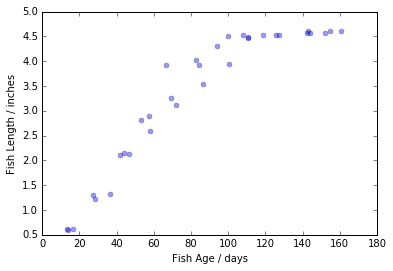

In [1]:
import dp4gp_datasets as datasets
import dp4gp
import GPy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fishdata = datasets.load_fishlength()

X = fishdata[:,1] #age of fishes (days)

Y = fishdata[:,3] #length of fishes (inches)
#Y[-1]-=400
X = X+np.random.randn(X.shape[0])*3.0 #adding some jitter to the dataset for demo purposes
plt.plot(X,Y,'o',alpha=0.4,markersize=5)
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')


In [2]:
test_inputs = np.arange(0,300,1)
pseudo_inputs = np.array([0,180])
lengthscales = 200.0
sigma = 0.1
delta = 0.01
eps = 100.0
sens = 4.0
normal = True

In [3]:
test_inputs = np.hstack([test_inputs,X])

In [4]:
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
scalings = {}
print np.max(normal_peroutput_msense)
normal_peroutput_msense /= np.mean(normal_peroutput_msense)
for i,o in zip(test_inputs,normal_peroutput_msense):
    scalings[i] = o
new_test_cov, new_normal_msense, new_pseudo_msense, new_normal_peroutput_msense, new_pseudo_peroutput_msense, new_normal_mu, new_pseudo_mu, new_K_normal, new_K_pseudo, new_normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,scale=scalings,calc_normal=True)

Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 1.00
Calculating K_NN
Calculating lambda
THING
(333, 33)
[[  2.43821699e-01   1.05962351e-01   5.81884049e-02 ...,  -2.56770712e-02
    1.04040871e-02   3.16634064e-02]
 [  2.39038401e-01   1.05031865e-01   5.84605854e-02 ...,  -2.52362113e-02
    9.52101204e-03   3.00890095e-02]
 [  2.34286571e-01   1.04095838e-01   5.87184431e-02 ...,  -2.47861704e-02
    8.65536444e-03   2.85346002e-02]
 ..., 
 [ -1.89633838e-02  -4.38575584e-03   3.08359709e-03 ...,   6.17463996e-02
    6.89844155e-02   7.13843845e-02]
 [ -8.26165624e-06  -9.34305189e-03  -9.81738706e-03 ...,   6.89844155e-02
    1.00444371e-01   1.16552295e-01]
 [  1.21667342e-02  -1.04754951e-02  -1.56226651e-02 ...,   7.13843845e-02
    1.16552295e-01   1.40610298e-01]]
2202.68854703
1.03621108285
Calculating covariance between test in

In [ ]:
msense = new_normal_msense #np.max(new_normal_peroutput_msense)
#msense = new_pseudo_msense
print normal_msense
print new_normal_msense
print pseudo_msense
print new_pseudo_msense
print np.max(new_normal_peroutput_msense)

In [ ]:
Ntests = 300
msense = pseudo_msense #normal_msense 
mu = pseudo_mu #normal_mu
for it in range(10):
    samp = dp4gp.draw_sample(test_cov, test_inputs, mu, msense, sens, delta, eps)
    plt.plot(test_inputs[0:Ntests],samp[0:Ntests],'k-',alpha=0.3)
samp = dp4gp.draw_sample(test_cov, test_inputs, mu, msense, 0, delta, 50000)
plt.plot(test_inputs[0:Ntests],samp[0:Ntests],'k-',lw=2)

noise_shape = np.sqrt(np.diag(test_cov))*sens*msense*np.sqrt(2*np.log(2/delta))/eps
#noise_shape = normal_peroutput_msense[:,None]*sens*np.sqrt(2*np.log(2/delta))/eps
covs = np.diag(normal_covars)[0:Ntests,None]+noise_shape[0:Ntests,None]**2

errorfilly = samp[0:Ntests,None]+np.sqrt(covs)
errorfilly = np.vstack([errorfilly[::-1],samp[0:Ntests,None]-np.sqrt(covs)])
errorfillx = test_inputs[0:Ntests]
errorfillx = np.hstack([errorfillx[::-1],test_inputs[0:Ntests]])
plt.fill(errorfillx,errorfilly,'k',alpha=0.2)
plt.plot(test_inputs[0:Ntests],samp[0:Ntests] + np.sqrt(np.diag(normal_covars))[0:Ntests],'k--')
plt.plot(test_inputs[0:Ntests],samp[0:Ntests] - np.sqrt(np.diag(normal_covars))[0:Ntests],'k--')

plt.plot(X,Y,'o',alpha=0.4,markersize=5)
plt.ylim([0,5])
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')

In [ ]:
Ntests = 300
msense = new_normal_msense #new_pseudo_msense
mu = new_normal_mu #new_pseudo_mu
for it in range(10):
    samp = dp4gp.draw_sample(new_test_cov, test_inputs, mu, msense, sens, delta, eps)
    plt.plot(test_inputs[0:Ntests],samp[0:Ntests],'k-',alpha=0.3)
samp = dp4gp.draw_sample(new_test_cov, test_inputs, mu, msense, 0, delta, 50000)
plt.plot(test_inputs[0:Ntests],samp[0:Ntests],'k-',lw=2)

noise_shape = np.sqrt(np.diag(new_test_cov))*sens*msense*np.sqrt(2*np.log(2/delta))/eps
#noise_shape = normal_peroutput_msense[:,None]*sens*np.sqrt(2*np.log(2/delta))/eps
covs = np.diag(new_normal_covars)[0:Ntests,None]+noise_shape[0:Ntests,None]**2

errorfilly = samp[0:Ntests,None]+np.sqrt(covs)
errorfilly = np.vstack([errorfilly[::-1],samp[0:Ntests,None]-np.sqrt(covs)])
errorfillx = test_inputs[0:Ntests]
errorfillx = np.hstack([errorfillx[::-1],test_inputs[0:Ntests]])
plt.fill(errorfillx,errorfilly,'k',alpha=0.2)
plt.plot(test_inputs[0:Ntests],samp[0:Ntests] + np.sqrt(np.diag(new_normal_covars))[0:Ntests],'k--')
plt.plot(test_inputs[0:Ntests],samp[0:Ntests] - np.sqrt(np.diag(new_normal_covars))[0:Ntests],'k--')

plt.plot(X,Y,'o',alpha=0.4,markersize=5)
plt.ylim([0,5])
plt.xlabel('Fish Age / days')
plt.ylabel('Fish Length / inches')
plt.savefig('funky_kernel.pdf')


In [ ]:
plt.plot(test_inputs[0:300],new_normal_peroutput_msense[0:300],'k-',label='New cloak')
plt.plot(test_inputs[0:300],normal_peroutput_msense[0:300],'b-',label='Old cloak')
plt.legend(loc='upper left')

In [ ]:
plt.plot(test_inputs[0:300],np.diag(test_cov)[0:300]);
plt.plot(test_inputs[0:300],np.diag(new_test_cov)[0:300],'--k');

### What happens if we repeat this?!?!?

In [ ]:
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)

for it in range(5):
    plt.subplot(2,1,1)
    plt.plot(test_inputs[0:300],np.diag(test_cov)[0:300],label='it %d' % it);
    plt.subplot(2,1,2)    
    plt.plot(test_inputs[0:300],normal_peroutput_msense[0:300],label='it %d' % it)
    scalings = {}
    for i,o in zip(test_inputs,normal_peroutput_msense):
        scalings[i] = o
    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,scale=scalings,calc_normal=True)
plt.subplot(2,1,1)
plt.legend()
plt.ylim([0,1.1])

plt.subplot(2,1,2)
plt.legend()

In [ ]:
(np.sqrt(np.diag(test_cov))[0:300]*sens*np.sqrt(2*np.log(2/delta))/eps).shape

In [ ]:
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
plt.figure(figsize=[5,16])
for it in range(6):
    plt.subplot(6,1,it+1)
    msense = np.max(normal_peroutput_msense)
    print msense
    for sampits in range(5):
        samp = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, msense, sens, delta, eps)
        plt.plot(test_inputs[0:300],samp[0:300],'k-',alpha=0.2)
    samp = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, msense, sens, delta, 50000)
    plt.plot(test_inputs[0:300],samp[0:300],'k-',lw=3)
    noise_shape = np.sqrt(np.diag(test_cov))*sens*msense*np.sqrt(2*np.log(2/delta))/eps
    plt.plot(test_inputs[0:300],samp[0:300]+np.sqrt(np.diag(normal_covars))[0:300],'b-',lw=1)    
    plt.plot(test_inputs[0:300],samp[0:300]-np.sqrt(np.diag(normal_covars))[0:300],'b-',lw=1)    
    plt.plot(test_inputs[0:300],samp[0:300,None]+noise_shape[0:300,None],'k-',lw=1)
    plt.plot(test_inputs[0:300],samp[0:300,None]-noise_shape[0:300,None],'k-',lw=1)
    scalings = {}
    normal_peroutput_msense /= np.max(normal_peroutput_msense)
    for i,o in zip(test_inputs,normal_peroutput_msense):
        scalings[i] = o
    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,scale=scalings,calc_normal=True)
    
    plt.plot(X,Y,'o',alpha=0.4,markersize=5)
    plt.ylim([0,5])
    if it==4:
        plt.xlabel('Fish Age / days')
    plt.ylabel('Fish Length / inches')
plt.savefig('iterative_application.pdf')

In [ ]:
plt.plot(normal_peroutput_msense[0:300]/np.max(normal_peroutput_msense[0:300]))
plt.title('Weird cloaking function after 6 iterations')
plt.xlabel('Age / days')
plt.ylabel('Cloaking scale ($\propto$ sensitivity)')
plt.savefig('weird.pdf')

# Plan C

In [2]:
def k(x1,x2,l):
    return np.exp(-.5 * (x1-x2)**2/l**2)

In [22]:
Ntest = 2
l = 1.0
M = np.zeros([Ntest,Ntest])
for i,x1 in enumerate(np.arange(0,1,0.5)):
    for j,x2 in enumerate(np.arange(0,1,0.5)):
        M[i,j] = k(x1,x2,l)

In [26]:
M

array([[ 1.       ,  0.8824969],
       [ 0.8824969,  1.       ]])

In [27]:
cov = np.linalg.inv(np.dot(M,M))

In [28]:
cov

array([[ 36.35466454, -36.07248114],
       [-36.07248114,  36.35466454]])

In [34]:
samps = np.random.multivariate_normal(np.zeros(2),cov,100)

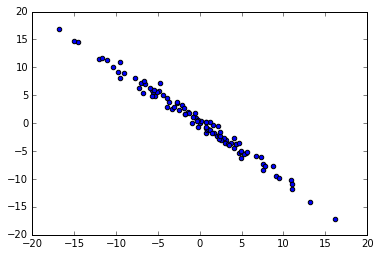

In [35]:
plt.scatter(samps[:,0],samps[:,1])

In [19]:
K_ss**-.5

array([[ 1.       ,  1.0006252],
       [ 1.0006252,  1.       ]])

In [17]:
deltav = np.array([1,1])
new = np.dot(K_ss**-.5,deltav)
tot = np.sqrt(np.sum(new**2))

print deltav
print new
print tot

[1 1]
[ 2.0006252  2.0006252]
2.82931128449


# New solution using the vector option...

In [1]:
import GPy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

warning in stationary: failed to import cython module: falling back to numpy


In [258]:
def gram_schmidt_columns(X):
    """The gram schmidt transform will provide orthogonal vectors. If the vectors we provide exist in a planar manifold
    the resulting vectors should remain in the manifold. TBC!!!"""
    Q, R = np.linalg.qr(X)
    return Q

def rotate_in_subspace(V,v = None,angleinvert=False):
    #creates a rotation matrix that rotates between two vectors
    #defined as the columns of V,
    #such that the rotation occurs in a plane defined by the two vectors
    #(as two vectors is insufficient to describe an arbitrary rotation in n-dimensions)

    #this used to be a single vector, but to generate a general matrix result:
    if v is None:
        v = np.eye(3) 
    
    #the two vectors now with length 1
    Vnormalised = V*np.repeat(1./np.sqrt(np.sum(V**2,0))[None,:],3,axis=0)

    #this is the same span but with orthonormal vectors (each column is one vector)
    #annoyingly this can swap the direction of a rotation...
    G = gram_schmidt_columns(V)

    #We find the matrix that projects from the space to the hyperplane subspace
    P = np.dot(G,G.T)

    #projected onto the plane
    vprime = np.dot(P,v)

    #the difference between v and vprime
    deltav = vprime-v

    #coord in basis
    coords = np.dot(G.T,vprime)

    #angle of the rotation
    ang = np.arccos(np.dot(Vnormalised[:,0],Vnormalised[:,1]))
    if angleinvert:
        ang = -ang

    #the rotation matrix in the 2d plane
    R = np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])

    #new coordinates on the plane
    newcoords = np.dot(R,coords)

    #reprojected back to the original basis
    vprimerotated =np.dot(G,newcoords)

    #translated back from the plane
    vrotated = vprimerotated-deltav    
    return vrotated

def adjusted_rotate_in_subspace(V,v=None):
    #Temporary fix - there's bound to be better!
    #the problem is when the gram schmidt orthonormal basis is created, the direction of rotation can be swapped.
    #as there's two choices, I simply find out whether we've got the right one...
    
    #we feed in the first vector in...
    new = rotate_in_subspace(V,V[:,0])
    new/=np.sqrt(np.sum(new**2))
    #we expect the result to be the second vector...
    targ=V[:,1]/np.sqrt(np.sum(V[:,1]**2))
    
    #we've normalised them both: They should be equal
    #if they're not...
    if np.sum((new-targ)**2)>0.01: #we need to swap the order of the vectors!
        #print "Flipped angle"
        return rotate_in_subspace(V,v,angleinvert=True)
    else:
        return rotate_in_subspace(V,v)

In [260]:
def k(x1,x2,l):
    return np.exp(-.5 * (x1-x2)**2/l**2)

In [307]:
tests = np.array([0,0.5,1]) #np.arange(-5,15,1.0)
train = np.array([0,0.2]) #np.arange(0,5,1.0)
l = 1.0
sigma = 0.1
delta = 0.01
eps = 1.0

Kstar = np.zeros([len(tests),len(train)])
for i,x in enumerate(tests):
    for j,y in enumerate(train):
        Kstar[i,j] = k(x,y,l)
K = np.zeros([len(train),len(train)])
for i,x in enumerate(train):
    for j,y in enumerate(train):
        K[i,j] = k(x,y,l)
K+=sigma**2*np.eye(len(train))

cloak = np.dot(Kstar,np.linalg.inv(K))
cov = np.eye(len(tests))*0.01 #np.zeros([len(tests),len(tests)])
for it in range(len(train)):
   # print cloak[:,it]
    newcov = (np.dot(cloak[:,it][:,None],cloak[:,it][None,:]))
    
    print "==============="
    
    evals,evects = np.linalg.eig(np.dot(np.linalg.inv(cov),newcov))
#    while np.any(evals>1.0):
#        indices = np.real(evals)>1.0                
#        e = evects[:,indices][:,0] #we'll just do one...
#        v = evals[indices][0]      
#        Smat = np.eye(len(e))
#        Smat[0]*=v
#        cov = np.dot(evects,np.dot(Smat,np.dot(np.linalg.inv(evects),cov)))
#        #cov += newcov * 0.1        
#        evals,evects = np.linalg.eig(np.dot(np.linalg.inv(cov),newcov))
        
    while np.any(evals>1.0):        
        cov += newcov * 0.1        
        evals,evects = np.linalg.eig(np.dot(np.linalg.inv(cov),newcov))

#cov = np.eye(cov.shape[0])
np.set_printoptions(suppress=True,precision=3)
import scipy
halfcov = np.real(scipy.linalg.sqrtm(cov))
invhalfcov = np.linalg.inv(halfcov)
assert np.sum(np.dot(halfcov,halfcov)-cov)<0.0001

#WRONG MATHS!
#inner = np.dot(invhalfcov, np.max(cloak,1))
#Delta = np.sqrt(np.sum(inner**2))
####

#cloak is a matrix which shows effect of every training point on every test point
#so the columns of M^-.5 x cloak are the results of   M^-.5 (v_D - v_D')   for each training input
#we therefore need to find ||.||_2 of each column, and then find the maximum (note, could swap order of sqrt and max, to save compute)
inner = np.dot(invhalfcov,cloak)
Delta = np.max(np.sqrt(np.sum(inner**2,0)))

if False:
    print "COV"
    print cov
    print "COV^.5"
    print halfcov
    print "COV^-.5"
    print invhalfcov
    print "cloak:"
    print cloak
    print "inner part of norm_2"
    print inner #inside 2-norm
    

c = np.sqrt(2*np.log(2/delta))

print "Delta"
print Delta

Delta
0.997580242173


In [303]:
cloak

array([[ 0.83 ,  0.165],
       [-0.771,  1.695],
       [-1.672,  2.342]])

In [81]:
invhalfcov

array([[  5.039,  -8.287,   5.829],
       [ -8.287,  18.914, -12.833],
       [  5.829, -12.833,   9.148]])

In [82]:
Delta

0.99975557571028217

In [83]:
cov

array([[ 0.717, -0.36 , -1.   ],
       [-0.36 ,  3.469,  5.259],
       [-1.   ,  5.259,  8.281]])

In [84]:
cloak

array([[ 0.83 ,  0.165],
       [-0.771,  1.695],
       [-1.672,  2.342]])

In [85]:
#samps = (c*Delta/eps)*np.random.multivariate_normal(np.zeros(len(tests)),cov,10000)
sampcov = ((c*Delta/eps)**2)*cov
samps = np.random.multivariate_normal(np.zeros(len(tests)),sampcov,1000)

In [86]:
np.diag(sampcov)

array([  7.591,  36.743,  87.705])

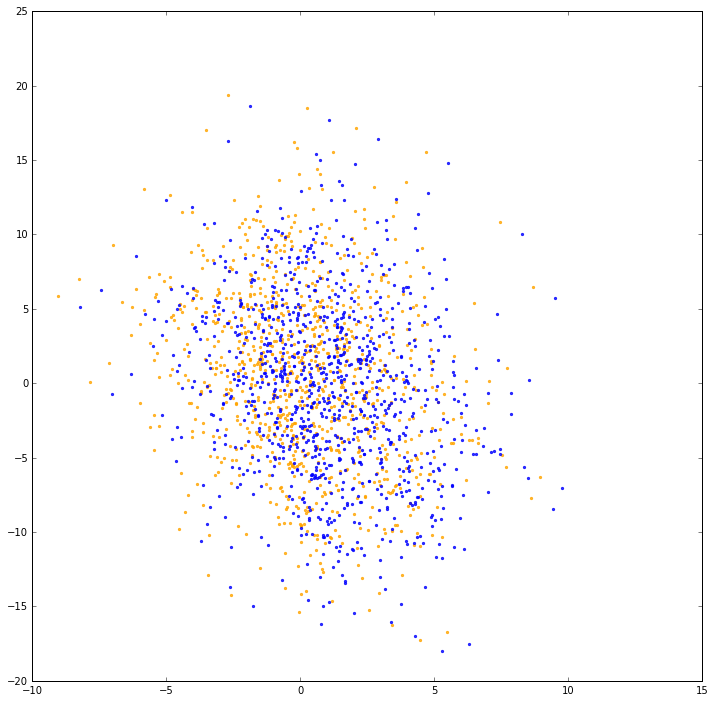

In [87]:
plt.figure(figsize=[12,12])
y = train.copy() #np.array([1,2,3,4,5])
mu = np.dot(Kstar,np.dot(np.linalg.inv(K),y))
fsamps = mu+samps
plt.scatter((fsamps)[:,0],(fsamps)[:,1],marker='.',color='orange',alpha=0.8)
y[0]+=1
mu_shift = np.dot(Kstar,np.dot(np.linalg.inv(K),y))
plt.scatter((mu_shift+samps)[:,0],(mu_shift+samps)[:,1],marker='.',color='b',alpha=0.8)

(-10.0, 10.0, -10.0, 10.0)

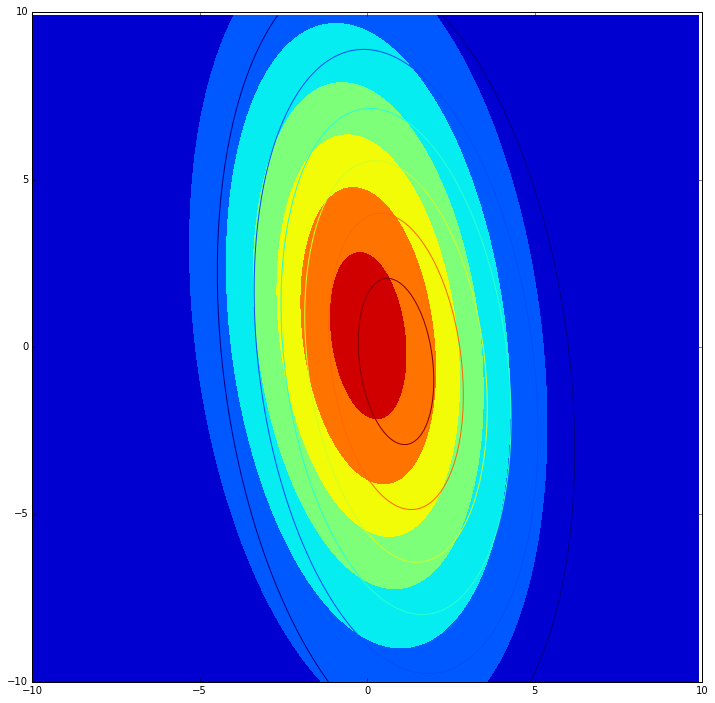

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,12])
from scipy.stats import multivariate_normal
stepsize = 0.1
histwidth = 10
x, y = np.mgrid[-histwidth:histwidth:stepsize, -histwidth:histwidth:stepsize]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
N = 0
rv_sample = multivariate_normal(mu[N:N+2], sampcov[N:N+2,N:N+2])
p = rv_sample.pdf(pos)
plt.contourf(x, y, p)
plt.axis('equal')
rv_sample_prime = multivariate_normal(mu_shift[N:N+2], sampcov[N:N+2,N:N+2])
q = rv_sample_prime.pdf(pos)
plt.contour(x, y, q)
plt.axis('equal')

In [89]:
threshold = 0.0022
#threshold = 0.0027
inc = (p>threshold) & (q>threshold)
print np.max(p[inc]/q[inc])
print np.sum(p[inc])*(stepsize**2)
print np.sum(p)*(stepsize**2)
print np.exp(eps)

1.62055354012
0.728239240832
0.900086940501
2.71828182846


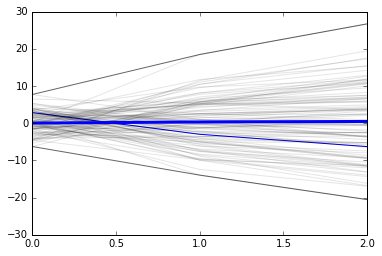

In [90]:
plt.plot(fsamps[np.random.randint(0,100),:].T);
plt.plot(fsamps[0:100,:].T,'k-',alpha=0.1);
plt.plot(np.max(fsamps[0:100,:].T,1),'k-',alpha=0.6);
plt.plot(np.min(fsamps[0:100,:].T,1),'k-',alpha=0.6);
plt.plot(mu,'b-',lw=3);

(0, 3)

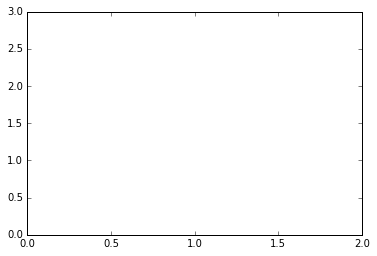

In [91]:
plt.plot(np.diag(sampcov))
plt.ylim([0,3])

### Vector calculations

In [257]:
V1 = np.array([[1,0,0],[0,1,1]]).T
R1 =adjusted_rotate_in_subspace(V1)
#V2 = np.array([[0,1,1],[1,0,1]]).T
#R2 = adjusted_rotate_in_subspace(V2)
V2 = np.array([[0,1,1],[1,0,0]]).T
R2 = adjusted_rotate_in_subspace(V2)

v = np.array([0,1,0])
#print v
#print np.dot(R1,v)
#print np.dot(R2,np.dot(R1,v))

v1 = adjusted_rotate_in_subspace(V1,v)
v2 = adjusted_rotate_in_subspace(V2,v1)
#print np.dot(R1,v),v1
#print np.dot(R2,np.dot(R1,v)),v2
#print np.dot(np.linalg.inv(R1),np.dot(R1,v))